# Day Low in 5m timeframe - Detection(Predict, Classification, Clustering)

### Import Library

In [181]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [182]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [183]:
data = dataset.copy()

In [184]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-11-19 14:10:00,1891.5,1892.7,1890.9,1891.5,4627
2025-11-19 14:15:00,1891.4,1891.5,1885.5,1885.8,12293
2025-11-19 14:20:00,1885.8,1887.0,1878.0,1880.3,14371


## Labeling data

In [185]:
def labeling_data(df):
    tmp_data = df.copy()
    tmp_data['DayLow'] = tmp_data['Low']
    daily_data = tmp_data.resample('D').agg({
            'DayLow': 'min'
        })
    daily_data.dropna(subset=['DayLow'], inplace=True)
    #
    data = df.copy()
    data = data.assign(time_d=pd.PeriodIndex(data.index, freq='1D').to_timestamp())
    #
    merged_data = pd.merge(data, daily_data, left_on="time_d", right_index=True, how="left")
    merged_data['hour'] = merged_data.index.hour
    merged_data['minute'] = merged_data.index.minute
    merged_data['prev_High'] = merged_data['High'].shift(1)
    merged_data['prev_Low'] = merged_data['Low'].shift(1)
    merged_data['prev_Close'] = merged_data['Close'].shift(1)
    merged_data['prev_Open'] = merged_data['Open'].shift(1)
    merged_data['prev_Vol'] = merged_data['Volume'].shift(1)
    merged_data['is_min'] = merged_data.apply(lambda r: 1 if r["Low"] == r["DayLow"] else 0, axis=1)
    ana_data = merged_data.dropna()
    ana_data['lower_shadow'] = ana_data.apply(lambda r: min(r["Open"], r["Close"]) - r["Low"], axis=1)
    ana_data['prev_lower_shadow'] = ana_data['lower_shadow'].shift(1)
    ana_data['ibs'] = ana_data.apply(
        lambda r: 0 if r["High"] == r["Low"] else (r["Close"] - r["Low"]) / (r["High"] - r["Low"]), axis=1)
    ana_data['prev_ibs'] = ana_data['ibs'].shift(1)
    ana_data['RSI20'] = ta.rsi(ana_data["Close"], length=20)
    ana_data['RSI10'] = ta.rsi(ana_data["Close"], length=10)
    ana_data['avg_Volume'] = ana_data['Volume'].rolling(20).mean()
    ana_data['prev_avg_Volume'] = ana_data['avg_Volume'].shift(1)
    ana_data["MB"] = ana_data["Close"].rolling(20).mean()
    ana_data["STD"] = ana_data["Close"].rolling(20).std()
    ana_data["LB"] = ana_data["MB"] - 1.5 * ana_data["STD"]
    ana_data["MFI_1d"] = ta.mfi(
        high=ana_data["High"],
        low=ana_data["Low"],
        close=ana_data["Close"],
        volume=ana_data["Volume"],
        length=50
    )
    ana_data["prev_MFI_1d"] = ana_data["MFI_1d"].shift(1)
    #
    ana_data['lower_wick_group'] = ana_data.apply(
        lambda r: 1 if r["lower_shadow"] > r["prev_lower_shadow"] else -1, axis=1)
    ana_data["ibs_vol_group"] = ana_data.apply(lambda r: get_ibs_vol_group(r), axis=1)
    ana_data['rsi_area'] = ana_data.apply(
        lambda r: 1 if r["RSI20"] > 55 else (0.33 if r["RSI20"] < 45 else 0.66), axis=1)
    ana_data['Lower_Low_higher_vol'] = ana_data.apply(
        lambda r: 1 if (r["Low"] < r["prev_Low"] and r["Volume"] > r["prev_Vol"]) else -1, axis=1)
    ana_data['Volume_higher_avg'] = ana_data.apply(lambda r: 1 if r["Volume"] > r["avg_Volume"] else -1, axis=1)
    ana_data['Volume_vs_prev_Vol'] = ana_data.apply(lambda r: 1 if r["Volume"] > r["prev_Vol"] else -1, axis=1)
    ana_data['Volume_avg_group'] = ana_data.apply(
        lambda r: 1 if r["avg_Volume"] > r["prev_avg_Volume"] else -1, axis=1)
    ana_data['close_price_group'] = ana_data.apply(lambda r: get_close_price_position(r), axis=1)
    ana_data['open_price_group'] = ana_data.apply(lambda r: get_open_price_position(r), axis=1)
    ana_data['Low_position'] = ana_data.apply(lambda r: 1 if r["Low"] < r["LB"] else -1, axis=1)
    ana_data['is_min_3'] = (ana_data["Low"] < ana_data["Low"].shift(1).rolling(3).min())
    ana_data['MFI_group'] = ana_data.apply(lambda r: 1 if r["MFI_1d"] > r["prev_MFI_1d"] else -1, axis=1)
    ana_data = ana_data[(100 * ana_data.index.hour + ana_data.index.minute > 905) & (100 * ana_data.index.hour + ana_data.index.minute != 1130) & (100 * ana_data.index.hour + ana_data.index.minute != 1430) & (100 * ana_data.index.hour + ana_data.index.minute != 1445)]
    ana_data.dropna(inplace=True)
    return ana_data


def get_open_price_position(r):
    if r["Open"] > r["prev_Close"]:
        return -0.5
    if r["Open"] == r["prev_Close"]:
        return 0
    if r["Open"] < r["prev_Close"]:
        return 0.5


def get_ibs_vol_group(r):
    if r["Volume"] > r["prev_Vol"] and r["ibs"] > r["prev_ibs"]:
        return -1
    if r["Volume"] > r["prev_Vol"] and r["ibs"] < r["prev_ibs"]:
        return -0.5
    if r["Volume"] < r["prev_Vol"] and r["ibs"] > r["prev_ibs"]:
        return 0.5
    if r["Volume"] < r["prev_Vol"] and r["ibs"] < r["prev_ibs"]:
        return 1


def get_close_price_position(r):
    if r["Close"] > r["prev_Low"]:
        return -1
    if r["Close"] > max(r["prev_Close"], r["prev_Open"]):
        return -0.5
    if max(r["prev_Close"], r["prev_Open"]) > r["Close"] > min(r["prev_Close"], r["prev_Open"]):
        return 0
    if r["Close"] < min(r["prev_Close"], r["prev_Open"]):
        return 0.5
    if r["Close"] < r["prev_Low"]:
        return 1


In [186]:
labeled_data = labeling_data(data)

## AI prediction

In [187]:
train_data = labeled_data[(labeled_data.index > '2020-01-01 00:00:00') & (labeled_data.index < '2025-01-01 00:00:00')]
test_data = labeled_data[labeled_data.index > '2025-01-01 00:00:00']

In [188]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve
from xgboost import plot_importance

In [189]:
features = [
    "lower_wick_group", "ibs_vol_group", "rsi_area", "Lower_Low_higher_vol",
    "Volume_higher_avg", "Volume_vs_prev_Vol", "Volume_avg_group", "is_min_3",
    "close_price_group", "open_price_group", "Low_position", "MFI_group"
]

In [190]:
X_train = train_data[features]
X_test = test_data[features]
y_train = train_data["is_min"]
y_test = test_data["is_min"]

In [191]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
ratio = neg / pos
print("scale_pos_weight =", ratio)

scale_pos_weight = 56.54218106995885


In [192]:
model_xgb = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,   # xử lý imbalance
    eval_metric="logloss",
    tree_method="hist"        # nhanh nhất
)

model_xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [193]:
model_xgb.save_model("xgb_long_model.json")

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

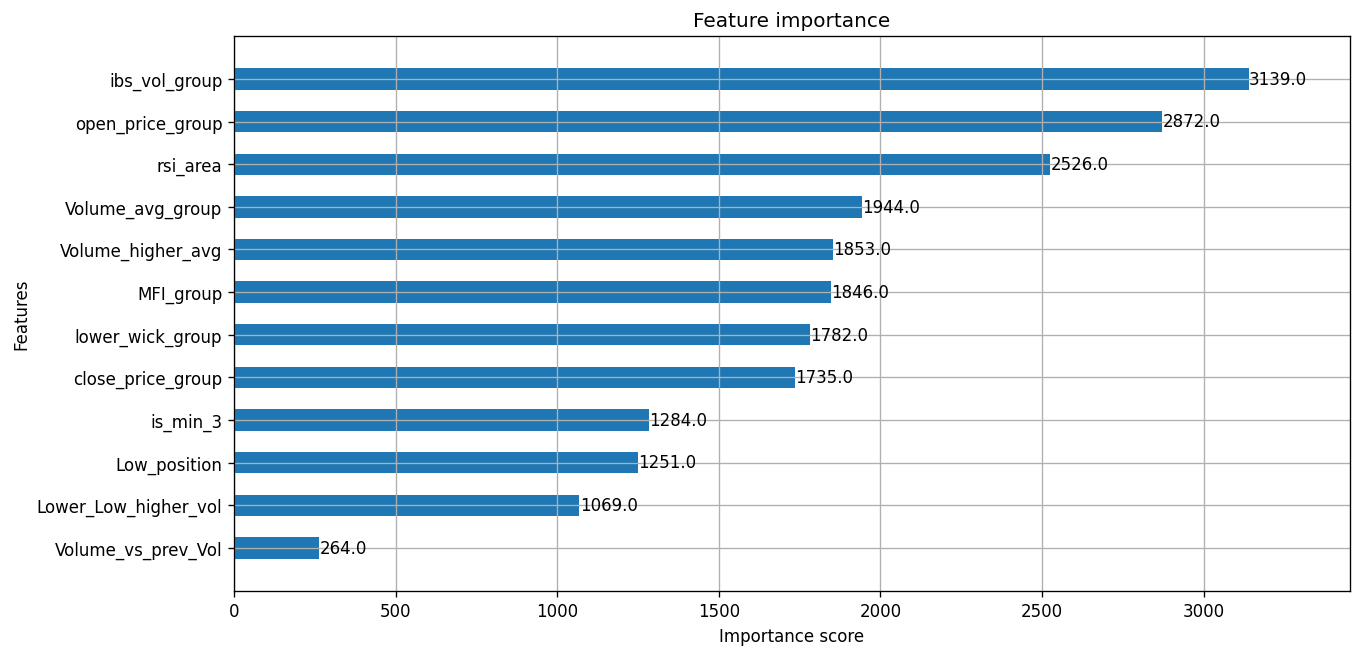

In [194]:
plot_importance(model_xgb, max_num_features=20, height=0.5)

In [195]:
proba = model_xgb.predict_proba(X_test)[:, 1]

In [196]:
print("AUC:", roc_auc_score(y_test, proba))

AUC: 0.9162664829388442


## Tối ưu threshold để có nhiều tín hiệu hơn

In [197]:
best_tx = 0
best_score = 0

for t in np.linspace(0.01, 1, 200):
    pred = (proba > t).astype(int)
    tp = np.sum((y_test == 1) & (pred == 1))
    tpx = np.sum((y_test == 0) & (pred == 1))
    score = tp * 5 - tpx
    if score > best_score:
        best_score = score
        best_t = t

print("Best threshold:", best_t)
print("Best score:", best_score)

Best threshold: 0.9303517587939699
Best score: 105


In [198]:
threshold = 0.92
pred = (proba > threshold).astype(int)

In [199]:
result = test_data.copy()
result['predict'] = pred
result['proba'] = proba

In [200]:
result[(result.index > "2025-11-01 00:00:00") & ((result.predict == 1) | (result.is_min == 1))][['is_min', 'predict', 'proba']]

,is_min,predict,proba
Date,,,
2025-11-03 10:00:00,0,1,0.952716
2025-11-03 14:25:00,1,0,0.872880
2025-11-04 13:15:00,0,1,0.949044
2025-11-04 13:20:00,0,1,0.920124
2025-11-04 13:25:00,1,1,0.957348
2025-11-05 09:30:00,1,0,0.623703
2025-11-06 10:55:00,0,1,0.946989
2025-11-06 13:50:00,0,1,0.946221
2025-11-07 10:30:00,0,1,0.946989
